In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

In [2]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8MB 163kB/s  eta 0:00:01
     |████████████████████████████████| 204kB 57.2MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [5]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-08-12 17:01:01--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-08-12 17:01:01--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-08-12 17:01:01--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [6]:
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [7]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

In [19]:
result_pdf.isnull().sum()

min_temperature    0
max_temperature    0
min_voltage        0
max_voltage        0
min_flowrate       0
max_flowrate       0
min_frequency      0
max_frequency      0
min_hardness       0
max_hardness       0
min_speed          0
max_speed          0
dtype: int64

In [21]:
df.count()-result.count()

7

In [23]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [24]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")

In [25]:
features = assembler.transform(result)

In [26]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

In [27]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

In [28]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

In [29]:
result_pca.count()

2051

In [30]:
rdd = result_pca.rdd.sample(False,0.8)

In [31]:
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()

In [32]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

In [33]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

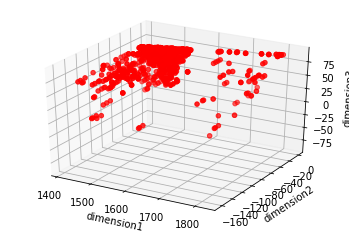

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

In [35]:
import numpy as np
import pandas as pd

In [42]:
df1 = df.select("*").toPandas()

In [44]:
df1.head()

,_id,_rev,count,flowrate,fluidlevel,frequency,hardness,speed,temperature,ts,voltage
0,0d86485d0f88d1f9d60bd193a4306793,1-57940679fb8a713bc46a033b3c495cbe,4,11.0,acceptable,NaN,77.0,NaN,100.0,1547808723923,NaN
1,0d86485d0f88d1f9d60bd193a4306ee1,1-15ff3a0b304d789e16a71f4b3e540920,2,NaN,None,NaN,NaN,1046.0,NaN,1547808729917,NaN
2,0d86485d0f88d1f9d60bd193a4307322,1-97c2742b68c7b07c2091d817e839f693,4,NaN,None,71.0,NaN,NaN,NaN,1547808731918,236.0
3,0d86485d0f88d1f9d60bd193a43080fc,1-eefb903dbe4574667b7410be306cf741,19,11.0,acceptable,NaN,75.0,NaN,86.0,1547808738999,NaN
4,0d86485d0f88d1f9d60bd193a4308701,1-5f68b4c72813c25e12d91004ddb33b1b,7,NaN,None,75.0,NaN,NaN,NaN,1547808740927,235.0


In [52]:
df1.describe()

,count,flowrate,frequency,hardness,speed,temperature,ts,voltage
count,2058.000000,1342.0,448.000000,1342.000000,268.000000,1342.000000,2.058000e+03,448.000000
mean,504.263848,11.0,70.361607,82.864382,1059.466418,90.038003,1.547809e+12,230.904018
std,394.261201,0.0,5.950846,21.762177,52.013852,6.100761,3.881533e+05,8.129664
min,1.000000,11.0,60.000000,70.000000,1000.000000,80.000000,1.547809e+12,220.000000
25%,172.000000,11.0,65.000000,73.000000,1025.750000,85.000000,1.547809e+12,224.000000
50%,381.000000,11.0,71.000000,76.000000,1049.000000,90.000000,1.547809e+12,230.000000
75%,827.750000,11.0,75.000000,79.000000,1081.000000,95.000000,1.547810e+12,236.000000
max,1342.000000,11.0,80.000000,195.000000,1289.000000,100.000000,1.547810e+12,258.000000


In [46]:
df1.isnull().sum()

_id               0
_rev              0
count             0
flowrate        716
fluidlevel      716
frequency      1610
hardness        716
speed          1790
temperature     716
ts                0
voltage        1610
dtype: int64

In [48]:
df1.corr()

,count,flowrate,frequency,hardness,speed,temperature,ts,voltage
count,1.000000,NaN,-0.069893,-0.063377,0.023745,0.001993,0.737786,0.055824
flowrate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
frequency,-0.069893,NaN,1.000000,NaN,NaN,NaN,-0.069897,0.027725
hardness,-0.063377,NaN,NaN,1.000000,NaN,0.017754,-0.063368,NaN
speed,0.023745,NaN,NaN,NaN,1.000000,NaN,0.023743,NaN
temperature,0.001993,NaN,NaN,0.017754,NaN,1.000000,0.001997,NaN
ts,0.737786,NaN,-0.069897,-0.063368,0.023743,0.001997,1.000000,0.055830
voltage,0.055824,NaN,0.027725,NaN,NaN,NaN,0.055830,1.000000


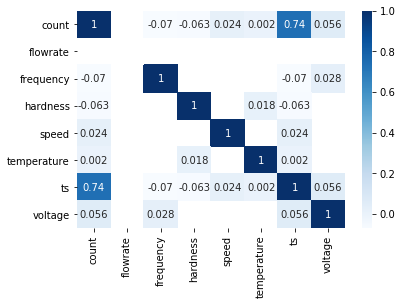

In [50]:
#Visualiztion of Correlations
import seaborn as sns
sns.heatmap(df1.corr(),annot=True,cmap="Blues")

In [36]:
result_pdf = result.select("*").toPandas()
result_pdf

,min_temperature,max_temperature,min_voltage,max_voltage,min_flowrate,max_flowrate,min_frequency,max_frequency,min_hardness,max_hardness,min_speed,max_speed
0,81,100,221,223,11,11,68,76,71,78,1033,1033
1,81,100,221,223,11,11,68,76,72,78,1033,1033
2,81,100,221,223,11,11,68,76,72,80,1033,1033
3,81,100,222,223,11,11,68,74,72,80,1033,1046
4,81,100,222,223,11,11,68,74,73,80,1033,1046
5,80,94,222,223,11,11,68,74,73,80,1033,1046
6,80,94,222,236,11,11,68,74,73,80,1046,1046
7,80,94,222,236,11,11,68,74,73,80,1046,1046
8,80,94,222,236,11,11,71,74,73,80,1046,1046
9,80,94,222,236,11,11,71,74,73,80,1046,1046


In [37]:
result_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 12 columns):
min_temperature    2051 non-null int64
max_temperature    2051 non-null int64
min_voltage        2051 non-null int64
max_voltage        2051 non-null int64
min_flowrate       2051 non-null int64
max_flowrate       2051 non-null int64
min_frequency      2051 non-null int64
max_frequency      2051 non-null int64
min_hardness       2051 non-null int64
max_hardness       2051 non-null int64
min_speed          2051 non-null int64
max_speed          2051 non-null int64
dtypes: int64(12)
memory usage: 192.4 KB


In [39]:
result_pdf.isnull().sum()

min_temperature    0
max_temperature    0
min_voltage        0
max_voltage        0
min_flowrate       0
max_flowrate       0
min_frequency      0
max_frequency      0
min_hardness       0
max_hardness       0
min_speed          0
max_speed          0
dtype: int64

In [41]:
result_pdf.corr()

,min_temperature,max_temperature,min_voltage,max_voltage,min_flowrate,max_flowrate,min_frequency,max_frequency,min_hardness,max_hardness,min_speed,max_speed
min_temperature,1.000000,0.068138,0.090862,0.112893,NaN,NaN,-0.038554,-0.059833,-0.016010,0.067804,-0.025613,0.015098
max_temperature,0.068138,1.000000,-0.045752,-0.024635,NaN,NaN,0.091090,0.012175,-0.101715,-0.035315,0.045080,-0.007337
min_voltage,0.090862,-0.045752,1.000000,0.699369,NaN,NaN,0.043794,0.017072,-0.086357,-0.074104,-0.051421,-0.042762
max_voltage,0.112893,-0.024635,0.699369,1.000000,NaN,NaN,0.021261,0.100531,-0.041914,-0.038551,-0.047067,-0.064350
min_flowrate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_flowrate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_frequency,-0.038554,0.091090,0.043794,0.021261,NaN,NaN,1.000000,0.436931,-0.060457,-0.053618,0.057069,0.090135
max_frequency,-0.059833,0.012175,0.017072,0.100531,NaN,NaN,0.436931,1.000000,0.018446,-0.001646,0.023360,-0.005854
min_hardness,-0.016010,-0.101715,-0.086357,-0.041914,NaN,NaN,-0.060457,0.018446,1.000000,0.659131,0.047224,0.076321
max_hardness,0.067804,-0.035315,-0.074104,-0.038551,NaN,NaN,-0.053618,-0.001646,0.659131,1.000000,0.100179,0.092076
